# Dear LEGO, what happened?!

I used to love playing with LEGO in the 90s when I was growing up, we built many crazy, moving-flying empires with my dad. But now, when I play with my kids, LEGO frustrates me more than anything. Instead of getting creative on building from the infinit stock of the "4er, 8er and some rods and wheels", there are highly specific bits, annoyingly non-matching shades and long users' manuals everwhere in our flat. Is it just me, or has LEGO fundamentally changed the shapes and colors of their bricks making them more complicated than ever? 

To answer this question, I used the data from [rebrickable](https://rebrickable.com/downloads/). This database actually updates daily. The data used in this analysis was downloaded today, on the 3 May 2024. 

After getting the right data, I will: 
- explore the amount of sets and their complexity (parts/set) over time
- find a popular theme (spoiler! it's Star Wars!) and look at the size of the set and unique colors over time
- then the coolest plot: color shades of all parts over time

As always, feedback is very welcome. Enjoy!

# Technical Preparation: Imports and Data

In [1]:
import csv
import gzip
import os

import numpy as np  # numpy == 1.21.2
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # for percentages
import seaborn as sns

%matplotlib inline

In [2]:
# Directory of gzipped files
data_dir = "data/"

# List of gzipped file paths
gz_files = ["colors.csv.gz", "elements.csv.gz", "inventories.csv.gz", "inventory_minifigs.csv.gz", 
            "inventory_parts.csv.gz", "inventory_sets.csv.gz", "part_categories.csv.gz", "part_relationships.csv.gz", 
            "sets.csv.gz", "minifigs.csv.gz", "themes.csv.gz", "parts.csv.gz"]

# Dictionary to store DataFrames
lego_datasets = {}

for file_name in gz_files:
    # construct full file path
    file_path = os.path.join(data_dir, file_name)
    
    data = []

    # Open the gzipped file
    with gzip.open(file_path, "rt") as file:
        reader = csv.reader(file) # CSV header
        columns = next(reader) # for header row
        for row in reader:
           data.append(row)

    # Create a pandas DataFrame
    df_name = file_name.split(".")[0]  # Extract filename without extension
    lego_datasets[df_name] = pd.DataFrame(data, columns = columns)


The datasets are related to each other and contain the following variables: ![](schema_v3.webp)



Let's take a look at the available data first. The smallest element is the parts: we have data on their color composition, themes they belong to, and it can all be arranged to sets, and then inventories. Taking a closer look it turns out that this data covers over 75 years (1949-2025)!

## Sets and Complexity Over Time

First let's see temporal trends. Is it possible that the reason for the overwhelming complexity of LEGOs is that they published much more sets over time? Or that sets are larger now than how they used to be? 

In [10]:
sets = lego_datasets['sets']

# Convert 'num_parts' column to numeric
sets = sets.copy()
sets.loc[:, 'num_parts'] = pd.to_numeric(sets['num_parts'])

sets_num_agg = sets.groupby('year').agg(
    sets=('set_num', 'count'),  # Count total sets
    parts=('num_parts', 'sum')    # Sum of num_parts
)

sets_num_agg.index = sets_num_agg.index.astype(int)

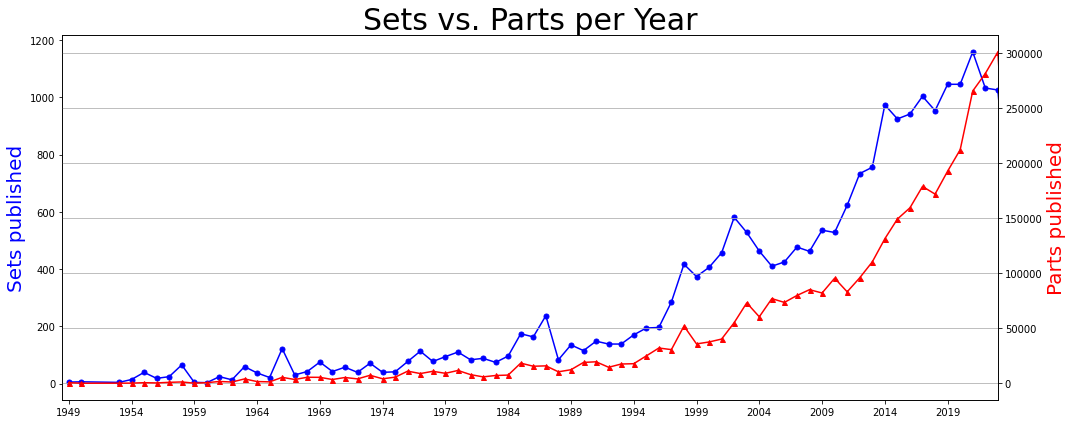

In [4]:
xticks = np.arange(min(sets_num_agg.index.values), max(sets_num_agg.index.values) -1, 5)

# Set plot
plt.style.use('seaborn-v0_8-bright')
fig, ax1 = plt.subplots(figsize=(15, 6))

year = sets_num_agg.index.values
sets = sets_num_agg['sets'].values
parts = sets_num_agg['parts'].values

ax1.plot(year, sets, color='blue', label='Sets published', marker='o', markersize = 5,)
ax1.set_ylabel('Sets published', color='blue', fontsize = 20)
ax1.set_xticks(year)
ax1.set_xlim(min(year) - 0.5, 2023)  # for completed years only

ax2 = ax1.twinx()  # Create a twin axis
ax2.plot(year, parts, color='red', label='Parts published', marker = '^', markersize = 5,)
ax2.set_ylabel('Parts published', color='red', fontsize = 20)

# Display settings
plt.title('Sets vs. Parts per Year', fontsize = 30)
plt.xlabel('Year')
plt.xticks(xticks)
plt.grid(True)
plt.tight_layout()

plt.show()

LEGO's popularity has never stopped growing: there are exponentially more sets being published every year. Consequently, there are also more parts published per year, although this growth is slower, meaning that sets are becoming slightly smaller over time. This trend seemed to stop in the past 3-4 years, although we shall see if this is a constant trend. Nevertheless, more sets also mean more divers parts being published, so that definitely contributes to modern-day chaos in "all LEGO parts". 

So we know the sets are more divers than ever. But what happens within a single theme that can potentially have more sets?

## Most common LEGO themes


I was actually wondering if the complexity was due to "simply" publishing more sets or that sets within the same theme became larger and more colorful. First let's see the Top 10 most LEGO themes (in terms of number of published sets). 

In [5]:
sets = lego_datasets['sets']
themes = lego_datasets["themes"]

# merge DFs to get parent theme
themes_common = sets.merge(themes, left_on = 'theme_id', right_on = 'id', how = 'left')
themes_common.rename(columns = {'name_y': 'theme_parent', 'name_x': 'theme_child'}, 
                     inplace = True)

# get Top 10 themes
themes_common_count = themes_common.groupby('theme_parent').size().reset_index(name='counts')
themes_common_count.sort_values(by='counts', ascending=False).head(10).reset_index(drop = True)

,theme_parent,counts
0,Star Wars,941
1,Technic,887
2,Key Chain,706
3,Gear,627
4,Friends,602
5,Ninjago,538
6,Bionicle,442
7,Town,423
8,Classic Town,411
9,Basic Set,386


Oh wow, almost a 1000 Star Wars sets were published since 1949! This is about 8 times more than Harry Potter in place 30 (around the 92th percentile). Partially because well, Harry Potter wasn't even born when Han Solo first kissed the mother of his future twins in the Millenial Falcon... So let's see what happened to Star Wars given that they came out (and trending) with multiple movies accross multiple decades. With some luck this can capture LEGO's intentions regarding the complexity of their sets with the same theme. 

## Star Wars Across Time

In [6]:
merged_df = lego_datasets['colors'] \
    .merge(lego_datasets['inventory_parts'], left_on='id', right_on='color_id', how='left') \
    .merge(lego_datasets['inventories'], left_on='inventory_id', right_on='id', how='left') \
    .merge(lego_datasets['sets'], left_on='set_num', right_on='set_num', how='left') \
    .merge(lego_datasets['themes'], left_on='theme_id', right_on='id', how='left')

# filter for Star Wars
star_wars_df = merged_df[merged_df['name'] == 'Star Wars']

# Convert 'num_parts' column to numeric
star_wars_df = star_wars_df.copy()
star_wars_df['num_parts'] = pd.to_numeric(star_wars_df['num_parts'])

# Group by year and count unique colors, total sets, and total parts
star_wars = star_wars_df.groupby('year').agg(
    unique_colors = ('id_x', 'nunique'),  # Count unique colors
    total_sets = ('set_num', 'count'),  # Count total sets
    total_parts = ('num_parts', 'sum')    # Sum of num_parts
)

star_wars['sets_parts'] = star_wars['total_parts'] / star_wars['total_sets']
star_wars['parts_std'] = star_wars_df.groupby('year')['num_parts'].std()
years = star_wars.index.astype(int)

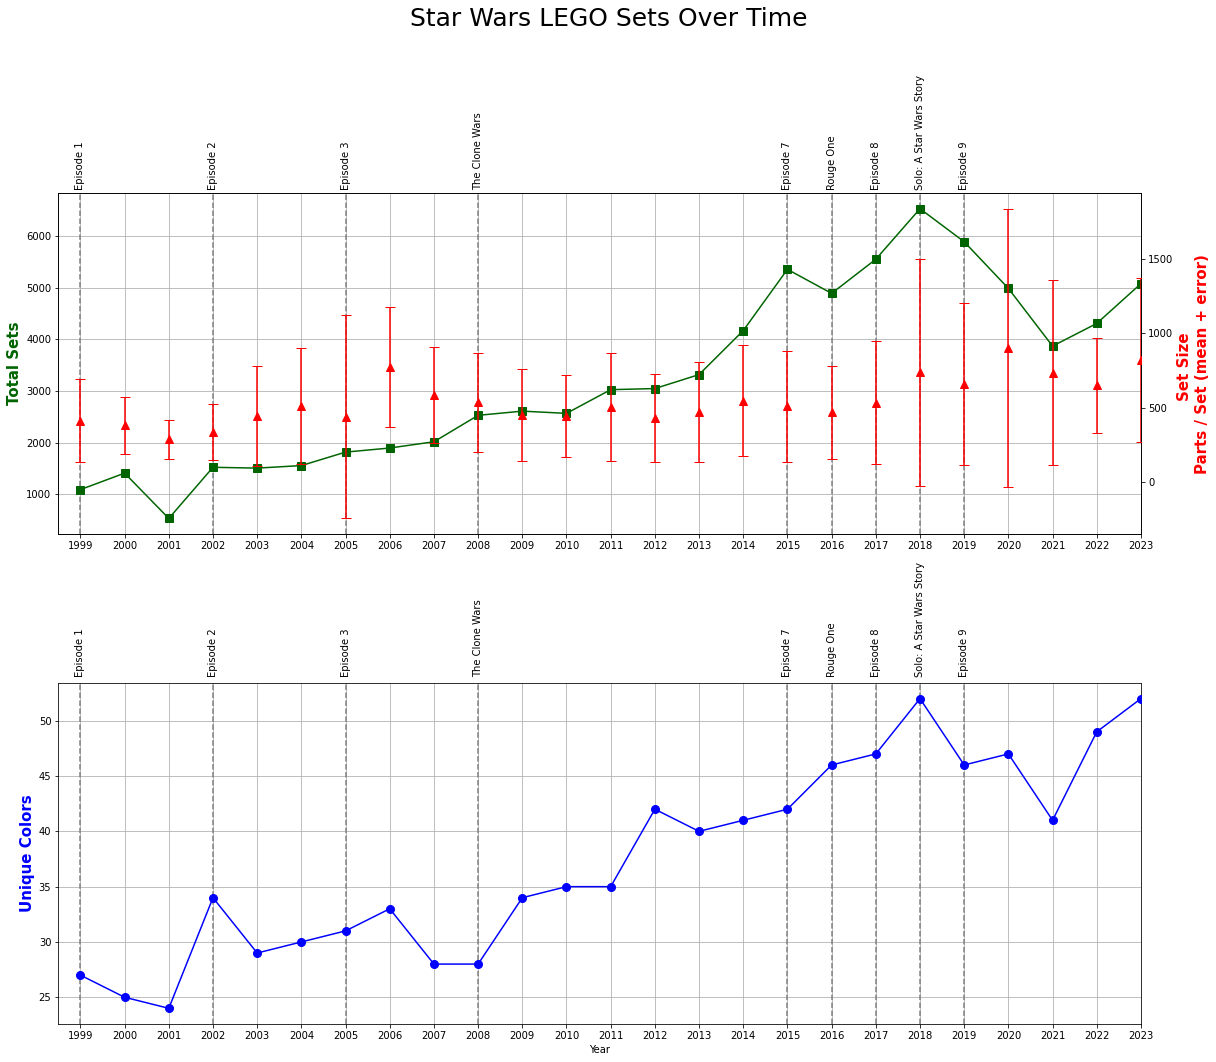

In [7]:
movies = {
    'Episode 1': 1999,
    'Episode 2': 2002,
    'Episode 3': 2005,
    'The Clone Wars': 2008,
    'Episode 7': 2015,
    'Rouge One': 2016,
    'Episode 8': 2017,
    'Solo: A Star Wars Story':2018,
    'Episode 9': 2019, 
}

# Add SW Episodes as vertical lines to the plot
def add_vertical_lines(ax):
    for movie, year in movies.items():
        ax.axvline(x=year, color='gray', linestyle='--', alpha=1, zorder=2)
        ax.text(year, ax.get_ylim()[1] * 1.01, movie, 
                rotation=90, verticalalignment='bottom', horizontalalignment='center', zorder=3)

# Create plot
plt.style.use('seaborn-v0_8-bright')
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(17, 15))

# FIRST PLOT (total sets & parts/sets)
total_sets_line, = ax1.plot(years, star_wars['total_sets'], 
                            color='darkgreen', marker='s', markersize=8,
                            label='Total Sets', zorder=3)
ax1.set_ylabel('Total Sets', fontsize=15, color='darkgreen', fontdict=dict(weight='bold'))
ax1.tick_params(axis='y')
ax1.grid(True)

# Create twin axis for sets_parts with error bars for standard deviation
ax2 = ax1.twinx()
sets_parts_line, _, _ = ax2.errorbar(years, star_wars['sets_parts'], 
                                     yerr=star_wars['parts_std'], fmt='^', color='red', markersize=8, 
                                     label='Parts / Set (average)', zorder=3, capsize=5)
ax2.set_ylabel('Set Size \nParts / Set (mean + error)', fontsize=15, color='red', fontdict=dict(weight='bold'))
ax2.tick_params(axis='y')
ax2.grid(False)

add_vertical_lines(ax1)

ax1.set_xticks(years)
ax1.set_xlim(min(years) - 0.5, 2023)  # for completed years only

# PLOT 2 (unique colors)
unique_colors_line, = ax3.plot(years, star_wars['unique_colors'], 
                               color='blue', marker='o', markersize=8,
                               label='Unique Colors', zorder=3)

ax3.set_xlabel('Year')
ax3.set_ylabel('Unique Colors', fontsize=15, color='blue', fontdict=dict(weight='bold'))
ax3.tick_params(axis='y')
ax3.grid(True)

add_vertical_lines(ax3)

ax3.set_xticks(years)
ax3.set_xlim(min(years) - 0.5, 2023)  # for completed years only

# Global display options
fig.suptitle('Star Wars LEGO Sets Over Time', fontsize=25)
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()


Suprisingly (to me) the first Star Wars LEGO set was published after Episode 1, which means that the initial triology in the 1980s was not commemorated. As the success of the Star Wars movies grew, so did the number of sets published, especially during the release of the latest trilogy (Episodes 4-6) increasing set numbers from around 1000 to about 4500, although at the peak (after Episode 5) set numbers reached 6500. Rearding the size of the sets: in the beginning there were on average about 350 parts per set, until the dark complexity of the siths (Episode 3) called for more volume - all of a sudden sets contained twice as more parts than before! The new, post-era, non-georgelucasian films also called for more parts apparently, increasing the average part/set number to around 700. 

Furthermore, there is also a constantly increasing trend of including more unique colors into the set each year, especially in the 2010s.

So yes, Star Wars LEGO sets undoubtedly got more numerious, larger and colorful over time.

## Color Composition Over Time 
I have a feeling there are just too many colors these days in LEGO sets so I wanted to see what actually happened to the color composition of sets in the past 75 years. This time I'll ignore the sets, and plot the relative occurance of part colors over time. Just like my kids do when they poor out all their LEGO parts in the middle of our livingroom (maybe they do relative counting of colors?).

By the way, this great idea for visualising came from [David Robinson](https://github.com/dgrtwo/data-screencasts/blob/master/2022_09_06_legos.Rmd) at Tidy Tuesday (written in R). 


In [8]:
sets_colors = lego_datasets['sets']\
                .merge(lego_datasets['inventories'], on='set_num', how = 'left')\
                .merge(lego_datasets['inventory_parts'], left_on = 'id', right_on = 'inventory_id', how = 'left')\
                .merge(lego_datasets['colors'], left_on = 'color_id', right_on = 'id', how = 'left')
sets_rgb = sets_colors[['year', 'name_y', 'rgb']].rename(columns = {'name_y':'color'}).set_index('year')
sets_rgb['rgb'] = '#' + sets_rgb['rgb']

# Create a pivot table to count occurrences of each 'rgb' value per 'year'
pivot_table = sets_rgb.pivot_table(index='year', columns='rgb', aggfunc='size', fill_value=0)

# Normalize the counts per yearS
sets_rgb_normalised = pivot_table.div(pivot_table.sum(axis=1), axis=0)


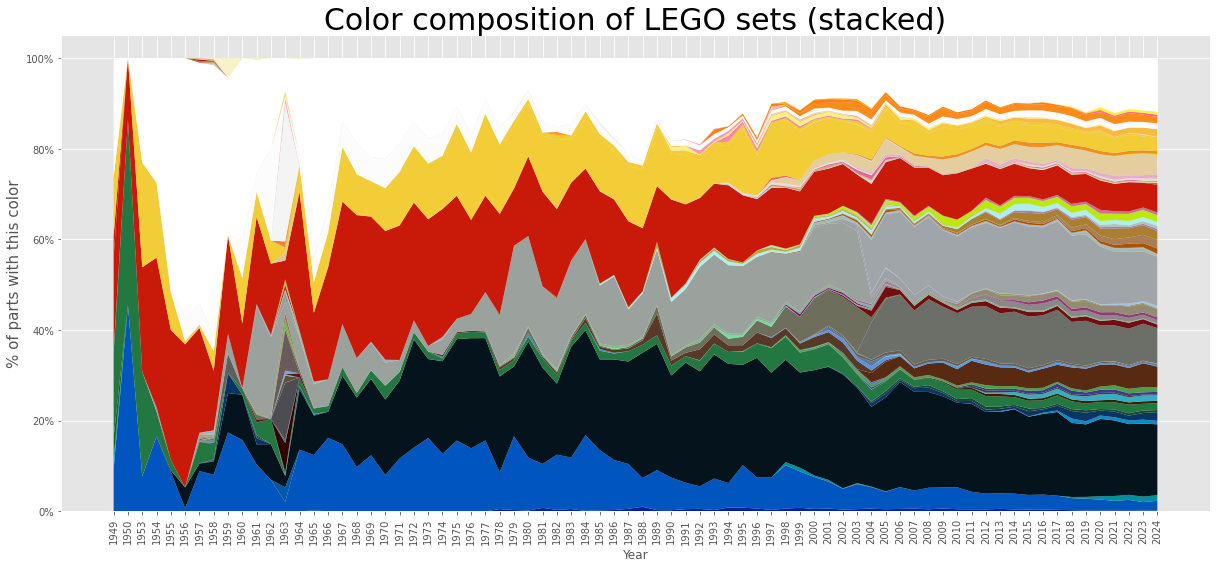

In [9]:
rgb_colors = list(sets_rgb_normalised)

years = sets_rgb_normalised.index
colors = []

for color in rgb_colors:
    colors.append(sets_rgb_normalised[color])

plt.style.use('ggplot')
                
plt.figure(figsize=(17, 8))

plt.stackplot(years, colors, 
              colors = rgb_colors)

plt.title('Color composition of LEGO sets (stacked)', fontsize = 30)
plt.xlabel('Year')
plt.ylabel('% of parts with this color', fontsize = 15)
plt.xticks(rotation = 90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format y-axis ticks as percentages
plt.tight_layout()
plt.show()


With time more shades of color appear: they started with 5 colors in 1949, and 75 year later there are over 3 dozen shades! This was already a trend in the '80s, but became striking in the 2000s and they didn't stop ever since. Hmm, it does seem like a generational difference... 

But there are other noteworthy trends too. 

Interesing to note, that the color _red_ took a smaller proportion of colors over time, and the same is true for _blue_ and for _white_, although to a lesser extent. Their place was taken by grey and more subtle shades of every color. There is a big "confusion" in colors in 1963 - this is apparently due to the fact that LEGO [started experimenting](https://www.newelementary.com/2017/01/old-bricks-5-classic-lego-colours.html) with colors. It was also in this year that they started producing the "color" _transparent_. This color actually accounts for about 30% of their production in that year. It is also interesting to note, that black parts were not really produced before the '60s. Indeed, according to the [official LEGO color timeline](https://www.flickr.com/photos/126975831@N07/15801189140), they only started producing black bricks in 1958, which apparently had technical resons: it was not possible to color the bricks black before given the composition of plastic. Nevertheless, it seems that once LEGO found a stable color trend in the '60s, they pretty much sticked to this relative composition of colors. I also find it interesing to note that they abruptly changed the shade of grey around 2003, so all of a sudden 'retro' and new grey bricks in the same household stopped being visual friends.

The complexity (the shades of color and size of set) is definitely on the rise by LEGO. It seems to me that they optimise for selling new,  color-matched sets, rather than prioritising backwards consistency. Shame, really, since plastic bricks are more undestroyable than anything especially accross generations, and it would be more esthetic to work with a single shade of gray instead of 4 different shades with my kids. Well, it is what it is: a first world problem!